[ 6 20  9 27 15 14  2  1 24  4 10 19 22 16 26 11  5  3  7  0 23 21 18  8
 25 17 13 12]


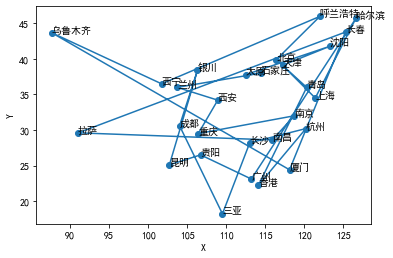

0 364.7934511921434
100 197.21802495493466
200 171.83067329417705
300 166.31725208419036
400 162.78684885570675
500 151.6957815499852
600 149.4369606176969
700 146.9933087523248
800 146.9933087523248
900 146.86826478806236
[7, 1, 12, 5, 13, 11, 8, 3, 4, 26, 10, 19, 17, 18, 21, 9, 22, 16, 6, 20, 15, 27, 0, 2, 23, 24, 25, 14]


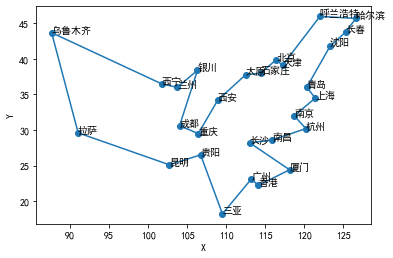

In [58]:
import numpy as np
import math
import pandas as pd
import random
import matplotlib.pyplot as plt

%matplotlib inline

#用来正常显示中文标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def draw(X,Y,L,s):
#     plt.cla()
#     fig = plt.figure()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.scatter(X, Y)
    for i in range(len(X)):
        #做标记
        plt.annotate(L[i],(X[i],Y[i]))
    X_s = []
    Y_s = []
    for i,j in enumerate(s):
        X_s.append(X[j])
        Y_s.append(Y[j])
    X_s.append(X[s[0]])
    Y_s.append(Y[s[0]])
    plt.plot(X_s, Y_s)
    #绘制散点
    plt.show()

def draw_distance(fD):
    plt.xlabel('iteration')
    plt.ylabel('distance')
    plt.plot(fD)
    plt.show()
    
def read_cities():
    df = pd.read_csv('city_location.csv',encoding = 'gb18030')
    df.columns=["city",'x','y']
    city = df["city"]
    x = df["x"]
    y = df["y"]
    cities = np.array(city)
    X = np.array(x)
    Y = np.array(y)
    n = len(X)
    return cities,X,Y,n

#TSP问题基因编码原则
#n个城市的的基因编码方式为：
#给每一个城市一个序号，如1->北京，2->上海，3->广州，。。。。，n->成都。
#用包含n个城市的序号的数组序列表示一种路线（个体），数组元素的序号表示旅行的顺序，如{3， 1， 2，。。。。，n}表示的旅行顺序为：广州->北京->上海->。。。。->成都。\n",
#数值序列中值不重复，即每个城市只去一次。t
#初始化，随机建立原始种群，容量为m
#随机生成m个城市序列作为初始种群
def initialize_population(m,n):
    p=[]
    for i in range(m):
        p.append(np.random.permutation(n))
    return p

def distance_between_point(x1,x2,y1,y2):
    return math.pow(math.pow(x2-x1,2)+math.pow(y2-y1,2),1/2)

#评估，评估个体适应度
#适应度取值为总距离的倒数，距离越短，适应度越强，即1/distance
def evaluate(s,X,Y):
    distance = 0
    n = len(s)
    for i in range(n-1):
        start = s[i]
        end = s[i+1]
        distance += distance_between_point(X[start],X[end],Y[start],Y[end])
    start = s[n-1]
    end = s[0]
    distance += distance_between_point(X[start],X[end],Y[start],Y[end])
    return distance

#选择，父子混合选择
#选用[轮盘赌选择]方法，适应力强的人被选择下的可能性更大,返回的是被选中的个体的下标
#1. 随机产生一个概率 selection_P 
#2. [概率分布函数]声明变量 distribution_P = 0, 对于每个个体, 依次累加个体的概率到distribution_P上, 判断当前随机概率selection_P是否小于distribution_P, 若是则中该染色体, 结束循环\n",
def choose(sum_evaluations,evaluations):
    selection_P = random.uniform(0,sum_evaluations)
    distribution_P = 0
    for i,e in enumerate(evaluations):
        distribution_P += e
        if distribution_P >=selection_P:
            return i

def generate_city(n,middle_p1):
    for i in range(n):
        if is_in_s(i,middle_p1)<0:
            return i
    
def is_in_s(n,s):
    for i,j in enumerate(s):
        if n==j:
            return i
    return -1

#交叉，基因交叉，产生后代
#TSP_杂交具体方法：
#随机生成两个交叉点，将交叉点之间的部分进行互换
#再分别对后代的冲突结点进行处理
#原则是保证交叉点之间结点不变，例：A冲突的7用B中7所对应的A中的那个值替换，因为B中的7替换到了A中，
#那么A中将不存在那个值，所以需要用交叉点之外的7去取这个值
def cross(p,p_cross,father_index,mother_index,X,Y):
#以杂交概率p_cross对母体进行交叉
    n = len(p[0])
    middle_p1 = []
    middle_p1.append(p[father_index][0])
    if(random.uniform(0,1)<p_cross):
        for i in range(1,n):
            start = middle_p1[i-1]
            father_start = is_in_s(start,p[father_index])
            father_end = p[father_index][(father_start+1)%n]
            mother_start = is_in_s(start,p[mother_index])
            mother_end = p[mother_index][(mother_start+1)%n]
            if(is_in_s(mother_end,middle_p1)==-1 and is_in_s(father_end,middle_p1)==-1):
                father_dis = distance_between_point(X[father_start],X[father_end],Y[father_start],Y[father_end])
                mother_dis = distance_between_point(X[mother_start],X[mother_end],Y[mother_start],Y[mother_end])
                if father_dis <= mother_dis:
                    middle_p1.append(father_end)
                else:
                    middle_p1.append(mother_end)
            elif (is_in_s(mother_end,middle_p1)>=0 and is_in_s(father_end,middle_p1)==-1):
                middle_p1.append(father_end)
            elif (is_in_s(mother_end,middle_p1)==-1 and is_in_s(father_end,middle_p1)>=0):
                middle_p1.append(mother_end)
            else:
                #随机生成一个未出现过的城市
                middle_p1.append(generate_city(n,middle_p1))
    else:
        middle_p1 = p[father_index].copy()
    return middle_p1
                

#变异，基因变异
#以一定的变异概率（确定变异个数）随机选择个体进行变异
#随机生成两个值，交换两个城市的位置
def variation(p_variation,middle_p):
    #以变异概率p_variation对中间个体进行变异产生新个体
    n = len(middle_p)
    if(random.uniform(0,1)<p_variation):
        variation_1 = random.randint(0,n-1)
        variation_2 = random.randint(0,n-1)
        while(variation_1 == variation_2):
            variation_2 = random.randint(0,n-1)
        middle_p[variation_1],middle_p[variation_2] = middle_p[variation_2],middle_p[variation_1]
    return middle_p  

#更新种群
#遗传变异产生的2*M个和本身的m个产生新的m个组成新的种群
def update_population(m,p,new_p,X,Y):
    p[m:2*m] = new_p
    distances={}
    for i,s in enumerate(p):
        distances[i]=evaluate(s,X,Y)
    a = sorted(distances.items(), key=lambda x: x[1])
    final_p = []
    for i in range(m):
        final_p.append(p[a[i][0]])
    return final_p

# def update_population(m,p,new_p,X,Y):
    

#遗传算法
#GA相关参数:变异概率p_variation、杂交概率p_cross、遗传次数iteration、初始群体规模m
def GA(p_variation=0.99,p_cross=0.8,iteration=1500,m=30):
    labels,X,Y,n =  read_cities()
    #初始化
    p = initialize_population(m,n)
    min_distances = []
    #执行iteration次进化
    for ite in range(iteration):
        #评估种群中所有个体
        m = len(p)
        sum_evaluations = 0
        min_dis = 10000
        evaluations = np.zeros(m)
        for i,s in enumerate(p):
            distance = evaluate(s,X,Y)
            evaluations[i] = 1/distance
            sum_evaluations += evaluations[i]
            if distance < min_dis:
                min_dis = distance
                min_s = s
        min_distances.append(min_dis)
        if(ite%iteration == 0 or ite==iteration-1):
            print(min_s)
            draw(X,Y,labels,min_s)
        if(ite%100 == 0):
            print(ite,min_dis)
#         print(ite,m)
#         print(m//2)
#         print(ite,p)
        #种群进化执行M次遗传，M = m/2
        new_p = []
        for i in range(m//2):
            #选择父亲母亲
            father_index = choose(sum_evaluations,evaluations)
            mother_index = choose(sum_evaluations,evaluations)
            #防止Father和Mother都是同一个个体
            while(father_index == mother_index):
                mother_index = choose(sum_evaluations,evaluations)
            #杂交\n",
            middle_p1 = cross(p,p_cross,father_index,mother_index,X,Y)
            middle_p2 = cross(p,p_cross,mother_index,father_index,X,Y)
#             print(middle_p1)
#             print(middle_p2)
            #变异
            new_p1 = variation(p_variation,middle_p1)
            new_p2 = variation(p_variation,middle_p2)
            new_p.append(new_p1)
            new_p.append(new_p2)
        #更新种群
        p = update_population(m,p,new_p,X,Y)
#         p = new_p
        
            
GA(iteration=1000,m=40)

